In [1]:
%pylab inline
import re
import math
import requests
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


In [2]:
TEXT = requests.get('https://norvig.com/big.txt').text

In [3]:
len(TEXT)

6488666

In [4]:
def tokens(text):
    """Return tokens list (letter sequences) in text. 
       Text becomes low-register."""
    return re.findall(r'[a-z]+', text.lower())

In [5]:
# tokens('This is: A test, 1, 2, 3, this is.')

In [6]:
WORDS = tokens(TEXT)
len(WORDS)

1105285

In [7]:
print(WORDS[:10])

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes']


# Модель: мешок слов

Мы создали список WORDS - список слов в том порядке, в котором они следуют в TEXT. Мы можем использовать этот список в качестве порождающей модели (generative model) текста. Язык - очень сложная штука и мы создаем крайне упрощенную модель языка, которая может ухватить часть этой сложной структуры. В модели мешка слов, мы полностью игнорируем порядок слов, зато соблюдаем их частоту. Представить это можно себе так: вы берете все слова текст и забрасываете их в мешок. Теперь, если вы хотите сгенерировать предложение с помощью этого мешка, вы просто трясете его (слова там перемешиваются) и достаете указанное количество слов по одному (мешок непрозрачный, так что слова вы достаете наугад). Почти наверное полученное предолжение будет грамматически некорректным, но слова в этом предложении будут в +- правильной пропорции (более частые будут встречаться чаще, более редкие - реже). Вот функция, которая сэмплирует предложение из n слов с помощью нашего мешка:

In [8]:
def sample(bag, n=10):
    """Сэмплируем случайную последовательность из n слов из модели, описанной нашим мешком слов."""
    return ' '.join(random.choice(bag) for _ in range(n))

In [9]:
sample(WORDS)

'tone applications removal such her him in is to injuries'

Другое представление мешка слов - Counter. Это словарь, состоящий из пар {'слово": количество вхождений слова в текст}. Например:

In [10]:
Counter(tokens('Is this a text? It is a text!'))

Counter({'is': 2, 'this': 1, 'a': 2, 'text': 2, 'it': 1})

Counter очень похож на словарь Python - dict, но у него есть ряд дополнительных методов. Давайте завернем в Counter наш список слов WORDS и посмотрим, что получится:

In [11]:
COUNTS = Counter(WORDS)

print(COUNTS.most_common(10))

[('the', 80030), ('of', 40025), ('and', 38313), ('to', 28766), ('in', 22050), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


In [12]:
for w in tokens('the rare and neverbeforeseen words'):
    print(COUNTS[w], w)

80030 the
83 rare
38313 and
0 neverbeforeseen
460 words


В 1935, лингвист Джордж Ципф отметил, что в любом большом тексте n-тое наиболее часто встречающееся слово появляется с частотой ~ 1/n от частоты наиболее часто встречающегося слова. Это наблюдение получило название Закона Ципфа, несмотря на то, что Феликс Ауэрбах заметил это еще в 1913 году. Если нарисовать частоты слов, начиная от самого часто встречающегося, на log-log-графике, они должны приблизительно следовать прямой линии, если закон Ципфа верен. Для нашего случая все, вроде бы, +- совпадает:

In [13]:
len(COUNTS)

29157

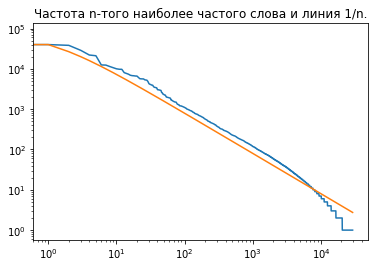

In [14]:
M = COUNTS['the']
yscale('log')
xscale('log')
title('Частота n-того наиболее частого слова и линия 1/n.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS))])

# Задача: проверка правописания

**Подход**: Найти все кандидаты c, достаточно близкие к w. Выбрать наиболее вероятные из них.

Применим наивный подход: всегда будем брать более близкое слово, если проверки на близость недостаточно, берем слово с максимальной частотой из WORDS. Сейчас мы будем измерять близость с помощью расстояния *Левенштейна*: минимального необходимого количества удалений, перестановок, вставок, и замен символов, необходимых чтобы одно слово превратить в другое.

In [15]:
def correct(word):
    """Поиск лучшего исправления ошибки для данного слова."""
    # Предрассчитать edit_distance=0, затем 1, затем 2; в противном случае оставить "как есть".
    candidates = (known(edits0(word)) or
                  known(edits1(word)) or
                  known(edits2(word)) or
                  [word])
    return max(candidates, key=COUNTS.get)

Функции known и edits0 простые: функция edits2 легко получается из функции edits1:

In [16]:
def known(words):
    """Вернуть подмножество слов, которые есть в нашем словаре."""
    return {w for w in words if w in COUNTS}

def edits0(word):
    """Вернуть все строки, которые находятся на edit_distance=0 от word (т.е. просто само слово)."""
    return {word}

def edits2(word):
    """Вернуть все строки, которые находятся на edit_distance=0 от word."""
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

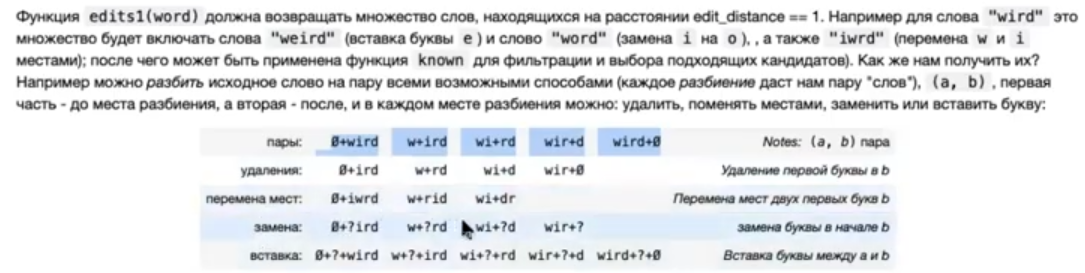

In [17]:
def edits1(word):
    """Возвращает список всех строк на расстоянии edit_distance == 1 от word."""
    pairs = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    """Возвращает список всех возможных разбиений на пару (a, b)."""
    return [(word[:i], word[i:])
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [18]:
splits('wird')

[('', 'wird'), ('w', 'ird'), ('wi', 'rd'), ('wir', 'd'), ('wird', '')]

In [19]:
len(alphabet)

26

In [20]:
print(edits0('wird'))

{'wird'}


In [21]:
print(edits1('wird'))

{'eird', 'weird', 'wierd', 'dwird', 'wirh', 'wnrd', 'wiurd', 'wivrd', 'mird', 'wicrd', 'wirb', 'wirbd', 'wjrd', 'wivd', 'gird', 'owird', 'ird', 'awird', 'wihd', 'oird', 'widrd', 'wirz', 'wisd', 'mwird', 'wirrd', 'wiyd', 'fird', 'wvird', 'witd', 'wirc', 'wkrd', 'wqrd', 'wirdq', 'qwird', 'wixd', 'wmrd', 'wiid', 'wbrd', 'wtird', 'wihrd', 'wirqd', 'rwird', 'cwird', 'wied', 'wirdw', 'wirdf', 'wirdv', 'wirdg', 'wirdk', 'hird', 'lird', 'wigd', 'wirsd', 'wnird', 'kird', 'wirs', 'ward', 'wgrd', 'wiwd', 'wirgd', 'wiud', 'wirdo', 'wirq', 'sird', 'zwird', 'wirvd', 'wirw', 'swird', 'wcrd', 'wiro', 'wira', 'wigrd', 'gwird', 'jwird', 'wirj', 'wiqrd', 'wwrd', 'wifd', 'wild', 'waird', 'wirdr', 'wuird', 'jird', 'wirwd', 'wirxd', 'witrd', 'wirde', 'wurd', 'uwird', 'werd', 'iird', 'wirzd', 'wtrd', 'wiri', 'wirx', 'wsird', 'wirdz', 'whrd', 'wimd', 'wpird', 'wir', 'wirdj', 'twird', 'wmird', 'wirdt', 'zird', 'wiprd', 'wirad', 'wxrd', 'rird', 'wibd', 'xwird', 'wind', 'vird', 'wirv', 'hwird', 'ywird', 'wjird',

In [22]:
print(len(edits2('wird')))

24254


In [23]:
tokens('Speling erurs in somethink. Whutever; unusuel misteakes everyware?')

['speling',
 'erurs',
 'in',
 'somethink',
 'whutever',
 'unusuel',
 'misteakes',
 'everyware']

In [24]:
list(map(correct, tokens('Speling erurs in somethink. Whutever; unusuel misteakes everyware?')))

['spelling',
 'hours',
 'in',
 'something',
 'whatever',
 'unusual',
 'mistakes',
 'everywhere']

Можно ли сделать выходные данные красивее?

In [25]:
def correct_text(text):
    """Исправить все слова с опечатками в тексте."""
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match):
    """Исправить слово word в match-группе, сохранив регистр: upper/lower/title."""
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    """Возвращает функцию регистра по тексту: upper, lower, title или str."""
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

In [26]:
str('fhgwdjksa')

'fhgwdjksa'

In [27]:
list(map(case_of, ['UPPER', 'lower', 'Title', 'CamelCase']))

[<method 'upper' of 'str' objects>,
 <method 'lower' of 'str' objects>,
 <method 'title' of 'str' objects>,
 str]

In [28]:
correct_text('Speling Errurs IN somethink. Whutever; unusuel misteakes?')

'Spelling Errors IN something. Whatever; unusual mistakes?'

In [29]:
correct_text('Audiance sayzs: tumblr ...')

'Audience says: tumbler ...'

# Теория: от счетчика слов к вероятностям последовательностей слов

Нам нужно научиться подсчитывать вероятности слов, _P(w)_. Делать мы это будем с помощью функции pdist, которая на вход принимает Counter (наш мешок слов) и возвращает функцию, выполняющую роль вероятностного распределения на множестве всех возможных слов. В вероятностном распределении вероятность каждого слова лежит между 0 и 1, и сложение вероятности всех слов даёт 1.

In [30]:
def pdist(counter):
    """Превращает частоты из Counter в вероятностное распределение."""
    N = sum(list(counter.values()))
    return lambda x: counter[x]/N

P = pdist(COUNTS)

In [31]:
for w in tokens('"The" is the most common word in English'):
    print(P(w), w)

0.07240666434449033 the
0.008842968103249388 is
0.07240666434449033 the
0.0008215075749693518 most
0.0002596615352601365 common
0.0002696137195383996 word
0.019949605757790978 in
0.00019090098933759167 english


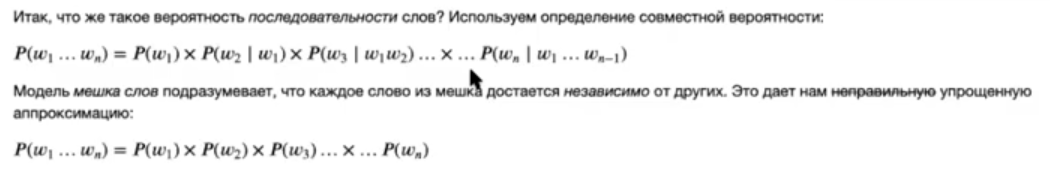

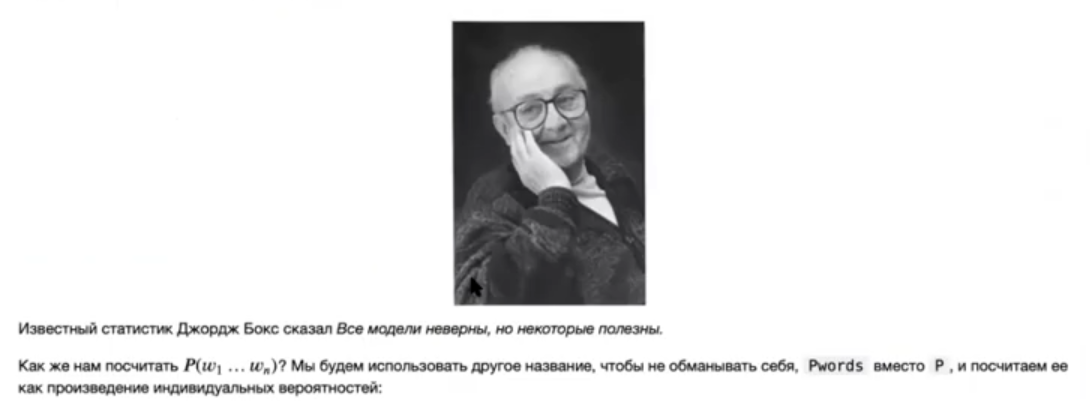

In [60]:
def Pwords(words):
    """Вероятности слов, при условии, что они независимы."""
    return product([P(w) for w in words])

def products(nums):
    """Перемножим числа. (Это как 'sum', только с умножением.)"""
    result = 1
    for x in nums:
        result *= x
    return result

In [63]:
tests = ['this is a test',
         'this is an unusual test',
         'this is a neverbeforeseen test']

for test in tests:
    print(Pwords(tokens(test)), test)

2.983396332800731e-11 this is a test
1.3975923769696695e-16 this is an unusual test
0.0 this is a neverbeforeseen test


# Задача: Разбиение слов на сегменты

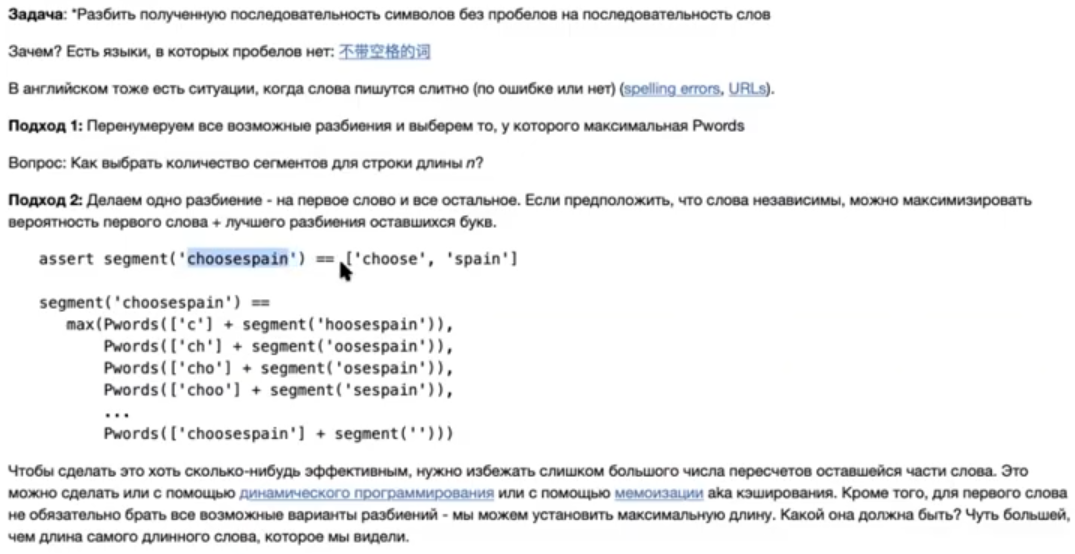

In [72]:
def memo(f):
    """Запомнить результаты исполнения функции f, чьи аргументы args должны быть хешируемыми."""
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    fmemo.cache = cache
    return fmemo

In [73]:
max(len(w) for w in COUNTS)

18

In [74]:
def splits(text, start=0, L=20):
    """Вернуть список всех пар (a, b); start <= len(a) <= L."""
    return [(text[:i], text[i:])
            for i in range(start, min(len(text), L)+1)]

In [75]:
print(splits('word'))
print(splits('reallylongtext', 1, 4))

[('', 'word'), ('w', 'ord'), ('wo', 'rd'), ('wor', 'd'), ('word', '')]
[('r', 'eallylongtext'), ('re', 'allylongtext'), ('rea', 'llylongtext'), ('real', 'lylongtext')]


In [76]:
@memo
def segment(text):
    """Вернуть список слов, который является наиболее вероятной сегментацией нашего текста."""
    if not text:
        return []
    else:
        candidates = ([first] + segment(rest)
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=Pwords)

Иллюстрацию того, что мемоизация - суперполезная штука, можно произвести на примере расчета чисел Фибоначчи. Если вы программист, они вам, наверняка, уже оскомину набили, но мы все равно на них посмотрим.

In [80]:
import time
@memo
def fib(n):
    if n < 2:
        return n
    return fib(n-2) + fib(n-1)

# какое число мы хотим посчитать
x = 40

t1 = time.perf_counter()
print(f'fib({x}) =', fib(x))
print(time.perf_counter() - t1)

fib(40) = 102334155
0.0005174999969312921


In [81]:
segment('choosespain')

['choose', 'spain']

In [82]:
segment('speedofart')

['speed', 'of', 'art']

In [83]:
decl = ('wheninthecourseofhumaneventsitbecomesnecessaryforpeople' +
        'todissolvethepoliticalbandswhichhaveconnectedthemwithoneanother' +
        'andtoassumeamongthepowersoftheearththeseparateandequalstation' +
        'towhichthelawsofnatureandofnaturesgodentitlethem')

In [85]:
print(segment(decl))

['when', 'in', 'the', 'course', 'of', 'human', 'events', 'it', 'becomes', 'necessary', 'for', 'people', 'to', 'dissolve', 'the', 'political', 'bands', 'which', 'have', 'connected', 'them', 'with', 'one', 'another', 'and', 'to', 'assume', 'among', 'the', 'powers', 'of', 'the', 'earth', 'the', 'separate', 'and', 'equal', 'station', 'to', 'which', 'the', 'laws', 'of', 'nature', 'and', 'of', 'natures', 'god', 'entitle', 'them']


In [86]:
Pwords(segment(decl))

3.6043381425711275e-141

In [87]:
Pwords(segment(decl * 2))

1.2991253445993085e-281

In [88]:
Pwords(segment(decl * 3))

0.0

Возникла проблема переполнения разрядности числа.

In [89]:
segment('smallandinsignificant')

['small', 'and', 'insignificant']

In [90]:
segment('largeandinsignificant')

['large', 'and', 'insignificant']

In [91]:
print(Pwords(['large', 'and', 'insignificant']))
print(Pwords(['large', 'and', 'in', 'significant']))

4.111418791681202e-10
1.0662753919897733e-11


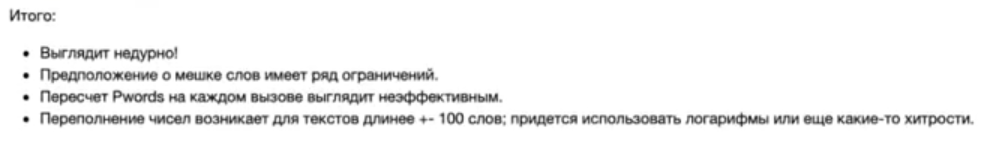

Этот ноутбук сделан по уроку [Видео урока](https://youtu.be/uqJV765l3sI)
Ссылка на ноутбук урока с доп.информацией [ноутбук урока](https://github.com/pileyan/webinar_spellchecker/blob/master/spellchecker_norvig%2B%2B.ipynb)